In [1]:
# === Block 0: Setup & Installations (run once) ===

# Core ML & fairness libs
!pip install --upgrade pip
!pip install transformers datasets scikit-learn pandas numpy matplotlib seaborn

# Fairlearn (in-processing)
!pip install fairlearn

# TensorFlow (required by AIF360 adversarial debiasing) - Using a recent, common version
!pip install tensorflow
# Try installing AIF360 (may require extra system deps on some machines)
!pip install aif360==0.6.0

In [2]:
# === Block 1: Setup Global Variables ===
SMALL_RUN = True  # set True to run on a small subset for quick CPU runs

In [3]:
# === Block 2: Imports and Helper Functions ===
import os
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Fairness libraries
try:
    from aif360.datasets import StandardDataset
    from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
    from aif360.algorithms.inprocessing import PrejudiceRemover
    from aif360.algorithms.inprocessing import AdversarialDebiasing
    from aif360.algorithms.postprocessing import (
        EqOddsPostprocessing, RejectOptionClassification, CalibratedEqOddsPostprocessing
    )
    AIF360_AVAILABLE = True
except Exception as e:
    print('AIF360 not available or failed to import:', e)
    AIF360_AVAILABLE = False

try:
    from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds
    from fairlearn.metrics import MetricFrame
    FAIRLEARN_AVAILABLE = True
except Exception as e:
    print('fairlearn not available or failed to import:', e)
    FAIRLEARN_AVAILABLE = False

def compute_group_rates(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    rate_priv = y_pred[priv_mask].mean() if priv_mask.sum() > 0 else np.nan
    rate_unpriv = y_pred[unpriv_mask].mean() if unpriv_mask.sum() > 0 else np.nan
    return rate_priv, rate_unpriv

def statistical_parity_difference(y_true, y_pred, protected_attr):
    # SPD = P(Y_pred=1|A=0) - P(Y_pred=1|A=1) -> closer to 0 is fairer
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    return r_unpriv - r_priv

def disparate_impact(y_true, y_pred, protected_attr):
    # DI = P(Y_pred=1|A=0) / P(Y_pred=1|A=1) -> closer to 1 is fairer
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    if r_priv == 0:
        return np.nan
    return r_unpriv / r_priv

def equal_opportunity_difference(y_true, y_pred, protected_attr):
    # EOD = P(Y_pred=1|A=0, Y_true=1) - P(Y_pred=1|A=1, Y_true=1) -> closer to 0 is fairer
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    def tpr(y_t, y_p, mask):
        # True Positive Rate (TPR) or Recall for the subgroup
        m = mask & (y_t == 1)
        return y_p[m].mean() if m.sum() > 0 else np.nan

    tpr_unpriv = tpr(y_true, y_pred, unpriv_mask)
    tpr_priv = tpr(y_true, y_pred, priv_mask)

    return tpr_unpriv - tpr_priv

def make_aif360_dataset(X_arr, y_arr, A_arr):
    # Create column names
    feat_names = [f'f{i}' for i in range(X_arr.shape[1])] + ['label', 'protected']

    # Create DataFrame
    df_temp = pd.DataFrame(X_arr, columns=[f'f{i}' for i in range(X_arr.shape[1])])
    df_temp['label'] = y_arr
    df_temp['protected'] = A_arr

    return StandardDataset(df_temp, label_name='label', favorable_classes=[1],
                           protected_attribute_names=['protected'], privileged_classes=[[1]])

pip install 'aif360[inFairness]'


In [4]:
# === Block 3: Data Loading (Bias in Bios) ===
from datasets import load_dataset
print('Loading Bias in Bios dataset (LabHC/bias_in_bios)...')
ds_train = load_dataset("LabHC/bias_in_bios", split='train')
df_raw = pd.DataFrame(ds_train)

# Use 'hard_text' as textual bio, 'profession' as target, 'gender' as protected attribute
df = pd.DataFrame()
df['text'] = df_raw['hard_text'].astype(str)
df['profession'] = df_raw['profession']
df['gender_raw'] = df_raw['gender']

# Heuristic to map numeric 'gender' codes to 'male' (1/privileged) and 'female' (0/unprivileged)
gender_codes = sorted(df['gender_raw'].unique())
pronoun_stats = {}
for code in gender_codes:
    # Only sample up to 1000 texts for a quick heuristic check
    sample_texts = df.loc[df['gender_raw'] == code, 'text'].astype(str).head(1000).str.lower()
    he_count = sample_texts.str.count(r'\bhe\b').sum()
    she_count = sample_texts.str.count(r'\bshe\b').sum()
    pronoun_stats[code] = {'he': int(he_count), 'she': int(she_count)}

# Decide mapping: whichever code has larger 'he' - 'she' difference is likely male (privileged=1)
male_code = None
max_diff = -1e9
for code, stats in pronoun_stats.items():
    diff = stats['he'] - stats['she']
    if diff > max_diff:
        max_diff = diff
        male_code = code

if male_code is None:
    male_code = gender_codes[0] # Fallback just in case

print(f'Inferred male gender code (privileged): {male_code}')

# Create readable gender string and numeric protected attribute column
df['gender'] = df['gender_raw'].apply(lambda code: 'male' if code == male_code else 'female')
df['protected'] = (df['gender_raw'] == male_code).astype(int)

# Create binary label: most-common profession code (1) vs others (0)
most_common_prof = df['profession'].value_counts().idxmax()
df['label'] = (df['profession'] == most_common_prof).astype(int)

# Respect SMALL_RUN for speed
if globals().get('SMALL_RUN', True):
    df = df.sample(n=min(5000, len(df)), random_state=42).reset_index(drop=True)
    print(f'Sampled for SMALL_RUN -> using rows: {len(df)}')

print('Label distribution:\n', df['label'].value_counts())
print('Gender distribution:\n', df['gender'].value_counts())

Loading Bias in Bios dataset (LabHC/bias_in_bios)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Inferred male gender code (privileged): 0
Sampled for SMALL_RUN -> using rows: 5000
Label distribution:
 label
0    3510
1    1490
Name: count, dtype: int64
Gender distribution:
 gender
male      2643
female    2357
Name: count, dtype: int64


In [5]:
# === Block 4: Text embeddings via Bloom (feature extraction) ===

# Using a smaller Bloom model for better CPU/Colab compatibility
TOKENIZER_NAME = 'bigscience/bloom-560m'
MODEL_NAME = 'bigscience/bloom-560m'

print("Loading tokenizer and model:", TOKENIZER_NAME)
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()

# Use GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print('Using device:', device)

# Embedding cache path
EMB_PATH = '/tmp/bloom_biasbios_embeddings.npy'

# Fallback for Bloom tokenizer's lack of a default padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id

if os.path.exists(EMB_PATH):
    embeddings = np.load(EMB_PATH)
    print('Loaded embeddings from cache:', EMB_PATH)
else:
    texts = df['text'].astype(str).tolist()
    batch_size = 32 if device.type == 'cuda' else 16  # smaller batch on CPU
    print(f'Encoding {len(texts)} texts with batch_size={batch_size} ...')
    all_embs = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            enc = tokenizer(batch_texts,
                            padding=True,
                            truncation=True,
                            return_tensors='pt',
                            max_length=128)

            input_ids = enc['input_ids'].to(device)
            attention_mask = enc['attention_mask'].to(device)

            # BLOOM does not use token_type_ids
            out = model(input_ids=input_ids, attention_mask=attention_mask)

            last_hidden = out.last_hidden_state.cpu().numpy()  # (bs, seq_len, hidden)
            mask = attention_mask.cpu().numpy()               # (bs, seq_len)

            # mean pooling (mask-aware)
            # Add a small epsilon to the denominator to prevent division by zero
            pooled = (last_hidden * mask[:,:,None]).sum(axis=1) / (mask.sum(axis=1)[:,None] + 1e-9)
            all_embs.append(pooled)

            if (i // batch_size) % 10 == 0:
                print(f'Processed {i + len(batch_texts)} / {len(texts)}')

    embeddings = np.vstack(all_embs)
    np.save(EMB_PATH, embeddings)
    print('Saved embeddings to', EMB_PATH)

print('Embeddings shape:', embeddings.shape)

Loading tokenizer and model: bigscience/bloom-560m
Using device: cuda
Loaded embeddings from cache: /tmp/bloom_biasbios_embeddings.npy
Embeddings shape: (5000, 1024)


In [6]:
# === Block 5 (updated): Train-test split and baseline logistic regression classifier ===
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
import warnings

# Optional: show warnings so you can inspect them, or suppress if you trust the settings
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

X = embeddings
y = df['label'].values
# 1 = privileged (male), 0 = unprivileged (female)
A = df['protected'].values

# stratify by label for balanced splits
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, A, test_size=0.30, random_state=42, stratify=y
)

print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])

# --- Scale features (fit scaler on train, apply to both sets) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train baseline classifier (saga is robust; max_iter increased to avoid convergence warnings)
clf = LogisticRegression(
    solver='saga',
    penalty='l2',
    max_iter=5000,
    tol=1e-4,
    random_state=42,
    n_jobs=-1
)

with warnings.catch_warnings():
    # Let sklearn still print the convergence warnings unless you uncomment suppression above
    clf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = clf.predict(X_test_scaled)
probs = None
try:
    probs = clf.predict_proba(X_test_scaled)[:, 1]
except Exception:
    # Some classifiers / rarer configs might not support predict_proba
    probs = None

print('Baseline accuracy:', accuracy_score(y_test, y_pred))
if probs is not None:
    try:
        print('Baseline ROC AUC:', roc_auc_score(y_test, probs))
    except Exception as e:
        print('ROC AUC error (maybe single class in test):', e)
else:
    print('Baseline ROC AUC: not available (predict_proba unsupported)')

# Evaluate baseline fairness metrics
spd = statistical_parity_difference(y_test, y_pred, A_test)
di = disparate_impact(y_test, y_pred, A_test)
eod = equal_opportunity_difference(y_test, y_pred, A_test)

print('\nBaseline SPD:', spd)
print('Baseline DI:', di)
print('Baseline EOD:', eod)

# --- Store all results ---
res_df = pd.DataFrame(
    [{'method': 'baseline',
      'accuracy': accuracy_score(y_test, y_pred),
      'SPD': spd,
      'DI': di,
      'EOD': eod}]
)

# Show results
print('\nres_df:')
print(res_df)


Train size: 3500 Test size: 1500
Baseline accuracy: 0.8906666666666667
Baseline ROC AUC: 0.9504366983859899

Baseline SPD: -0.023431446063649497
Baseline DI: 0.922437131601552
Baseline EOD: -0.002431512400713154

res_df:
     method  accuracy       SPD        DI       EOD
0  baseline  0.890667 -0.023431  0.922437 -0.002432


In [7]:
import time
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# fairlearn imports (assume present)
# from fairlearn.reductions import ExponentiatedGradient, GridSearch, EqualizedOdds, DemographicParity

def quick_checks(X_train, y_train, A_train):
    print("Shapes:", X_train.shape, y_train.shape, getattr(A_train, "shape", None))
    print("NaNs in X,y,A:", np.any(np.isnan(X_train)), np.any(np.isnan(y_train)), np.any(np.isnan(A_train)))
    print("Infs in X,y,A:", np.any(np.isinf(X_train)), np.any(np.isinf(y_train)), np.any(np.isinf(A_train)))

if 'FAIRLEARN_AVAILABLE' in globals() and FAIRLEARN_AVAILABLE:
    print('Running Fairlearn In-processing methods (Option A: pre-scale)...')

    quick_checks(X_train, y_train, A_train)

    # Run a quick small subset test (to see if methods finish quickly)
    SUBSET = min(1000, len(X_train))  # reduce if dataset is huge
    X_train_test = X_train[:SUBSET]
    y_train_test = y_train[:SUBSET]
    A_train_test = A_train[:SUBSET]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_test)
    X_test_scaled  = scaler.transform(X_test[:min(len(X_test), SUBSET)])

    base_est = LogisticRegression(solver='saga', penalty='l2', max_iter=500, tol=1e-3, random_state=42)

    # 1) ExponentiatedGradient (timed)
    try:
        print("Starting ExponentiatedGradient.fit() on subset...")
        t0 = time.time()
        eg = ExponentiatedGradient(base_est, constraints=EqualizedOdds(), eps=0.01)
        eg.fit(X_train_scaled, y_train_test, sensitive_features=A_train_test)
        t1 = time.time()
        print(f"EG fit finished in {t1 - t0:.2f}s")

        y_pred_eg = eg.predict(X_test_scaled)
        eg_acc = accuracy_score(y_test[:len(y_pred_eg)], y_pred_eg)
        eg_spd = statistical_parity_difference(y_test[:len(y_pred_eg)], y_pred_eg, A_test[:len(y_pred_eg)])
        eg_di = disparate_impact(y_test[:len(y_pred_eg)], y_pred_eg, A_test[:len(y_pred_eg)])
        eg_eod = equal_opportunity_difference(y_test[:len(y_pred_eg)], y_pred_eg, A_test[:len(y_pred_eg)])

        res_df.loc[len(res_df)] = {'method': 'expgrad_subset', 'accuracy': eg_acc, 'SPD': eg_spd, 'DI': eg_di, 'EOD': eg_eod}
        print(f'EG Results (subset) - Acc: {eg_acc:.4f}, SPD: {eg_spd:.4f}, DI: {eg_di:.4f}, EOD: {eg_eod:.4f}')
    except Exception as e:
        print(f'ExponentiatedGradient (subset) failed or hung: {e}')

    # 2) GridSearch (timed, very small grid_size)
    try:
        print("Starting GridSearch.fit() on subset (grid_size=3)...")
        t0 = time.time()
        gs = GridSearch(base_est, constraints=DemographicParity(), grid_size=3)
        gs.fit(X_train_scaled, y_train_test, sensitive_features=A_train_test)
        t1 = time.time()
        print(f"GridSearch fit finished in {t1 - t0:.2f}s")

        y_pred_gs = gs.predict(X_test_scaled)
        gs_acc = accuracy_score(y_test[:len(y_pred_gs)], y_pred_gs)
        gs_spd = statistical_parity_difference(y_test[:len(y_pred_gs)], y_pred_gs, A_test[:len(y_pred_gs)])
        gs_di = disparate_impact(y_test[:len(y_pred_gs)], y_pred_gs, A_test[:len(y_pred_gs)])
        gs_eod = equal_opportunity_difference(y_test[:len(y_pred_gs)], y_pred_gs, A_test[:len(y_pred_gs)])

        res_df.loc[len(res_df)] = {'method': 'gridsearch_subset', 'accuracy': gs_acc, 'SPD': gs_spd, 'DI': gs_di, 'EOD': gs_eod}
        print(f'GS Results (subset) - Acc: {gs_acc:.4f}, SPD: {gs_spd:.4f}, DI: {gs_di:.4f}, EOD: {gs_eod:.4f}')
    except Exception as e:
        print(f'GridSearch (subset) failed or hung: {e}')

    print("\nIf the subset runs fine, try increasing sizes stepwise until you find where it becomes slow.")
else:
    print('fairlearn not available — skipping ExponentiatedGradient & GridSearch')


Running Fairlearn In-processing methods (Option A: pre-scale)...
Shapes: (3500, 1024) (3500,) (3500,)
NaNs in X,y,A: False False False
Infs in X,y,A: False False False
Starting ExponentiatedGradient.fit() on subset...
EG fit finished in 1225.91s
EG Results (subset) - Acc: 0.8940, SPD: -0.0522, DI: 0.8392, EOD: -0.0428
Starting GridSearch.fit() on subset (grid_size=3)...
GridSearch fit finished in 10.90s
GS Results (subset) - Acc: 0.8940, SPD: -0.0522, DI: 0.8392, EOD: -0.0428

If the subset runs fine, try increasing sizes stepwise until you find where it becomes slow.


In [8]:
# # === Block 6: Fairlearn In-processing — Option A (pre-scale) ===
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression

# if 'FAIRLEARN_AVAILABLE' in globals() and FAIRLEARN_AVAILABLE:
#     print('Running Fairlearn In-processing methods (Option A: pre-scale)...')

#     # Pre-scale once
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled  = scaler.transform(X_test)

#     base_est = LogisticRegression(solver='saga', penalty='l2', max_iter=5000, tol=1e-4, random_state=42)

#     # ExponentiatedGradient
#     try:
#         eg = ExponentiatedGradient(base_est, constraints=EqualizedOdds(), eps=0.01)
#         eg.fit(X_train_scaled, y_train, sensitive_features=A_train)
#         y_pred_eg = eg.predict(X_test_scaled)

#         eg_acc = accuracy_score(y_test, y_pred_eg)
#         eg_spd = statistical_parity_difference(y_test, y_pred_eg, A_test)
#         eg_di = disparate_impact(y_test, y_pred_eg, A_test)
#         eg_eod = equal_opportunity_difference(y_test, y_pred_eg, A_test)

#         res_df.loc[len(res_df)] = {'method': 'expgrad', 'accuracy': eg_acc, 'SPD': eg_spd, 'DI': eg_di, 'EOD': eg_eod}
#         print(f'EG Results - Acc: {eg_acc:.4f}, SPD: {eg_spd:.4f}, DI: {eg_di:.4f}, EOD: {eg_eod:.4f}')
#     except Exception as e:
#         print(f'ExponentiatedGradient failed: {e}')

#     # GridSearch
#     try:
#         gs = GridSearch(base_est, constraints=DemographicParity(), grid_size=5)
#         gs.fit(X_train_scaled, y_train, sensitive_features=A_train)
#         y_pred_gs = gs.predict(X_test_scaled)

#         gs_acc = accuracy_score(y_test, y_pred_gs)
#         gs_spd = statistical_parity_difference(y_test, y_pred_gs, A_test)
#         gs_di = disparate_impact(y_test, y_pred_gs, A_test)
#         gs_eod = equal_opportunity_difference(y_test, y_pred_gs, A_test)

#         res_df.loc[len(res_df)] = {'method': 'gridsearch', 'accuracy': gs_acc, 'SPD': gs_spd, 'DI': gs_di, 'EOD': gs_eod}
#         print(f'GS Results - Acc: {gs_acc:.4f}, SPD: {gs_spd:.4f}, DI: {gs_di:.4f}, EOD: {gs_eod:.4f}')
#     except Exception as e:
#         print(f'GridSearch failed: {e}')

#     # Show updated results table
#     print('\nUpdated results (last rows):')
#     print(res_df.tail(10))
# else:
#     print('fairlearn not available — skipping ExponentiatedGradient & GridSearch')


In [9]:
# === Block 7: AIF360 in-processing (PrejudiceRemover, AdversarialDebiasing) ===

# Defensive defaults
sess = None

try:
    # Imports (may raise ImportError if not installed)
    from aif360.algorithms.inprocessing import PrejudiceRemover, AdversarialDebiasing
    from aif360.metrics import BinaryLabelDatasetMetric  # if needed
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()  # use TF1 behavior required by AIF360 adversarial implementation
    TF_AVAILABLE = True
except Exception as e:
    print(f'Could not import AIF360 or TensorFlow (compat.v1). Skipping in-processing methods. Error: {e}')
    TF_AVAILABLE = False

if 'AIF360_AVAILABLE' in globals() and AIF360_AVAILABLE and TF_AVAILABLE:
    try:
        # Prepare AIF360 Datasets (assumes make_aif360_dataset is defined earlier and returns a BinaryLabelDataset)
        aif_train = make_aif360_dataset(X_train, y_train, A_train)
        aif_test = make_aif360_dataset(X_test, y_test, A_test)

        privileged_groups = [{'protected': 1}]
        unprivileged_groups = [{'protected': 0}]

        # --- PrejudiceRemover ---
        print('\nRunning PrejudiceRemover...')
        try:
            pr = PrejudiceRemover(eta=25.0)
            pr.fit(aif_train)
            ypred_pr = pr.predict(aif_test).labels.ravel()

            pr_acc = accuracy_score(y_test, ypred_pr)
            pr_spd = statistical_parity_difference(y_test, ypred_pr, A_test)
            pr_di = disparate_impact(y_test, ypred_pr, A_test)
            pr_eod = equal_opportunity_difference(y_test, ypred_pr, A_test)

            res_df.loc[len(res_df)] = {
                'method': 'prejudiceremover',
                'accuracy': pr_acc,
                'SPD': pr_spd,
                'DI': pr_di,
                'EOD': pr_eod
            }
            print(f'PR Results - Acc: {pr_acc:.4f}, SPD: {pr_spd:.4f}, DI: {pr_di:.4f}, EOD: {pr_eod:.4f}')

        except Exception as e:
            print(f'PrejudiceRemover failed: {e}')

        # --- AdversarialDebiasing ---
        print('\nRunning AdversarialDebiasing (may be slow on CPU)...')
        try:
            # ensure a fresh graph/session
            tf.reset_default_graph()
            sess = tf.Session()
            adv = AdversarialDebiasing(
                privileged_groups=privileged_groups,
                unprivileged_groups=unprivileged_groups,
                scope_name='adv',
                debias=True,
                sess=sess,
                num_epochs=5  # reduced for speed; increase for better results
            )
            adv.fit(aif_train)
            ypred_adv = adv.predict(aif_test).labels.ravel()

            adv_acc = accuracy_score(y_test, ypred_adv)
            adv_spd = statistical_parity_difference(y_test, ypred_adv, A_test)
            adv_di = disparate_impact(y_test, ypred_adv, A_test)
            adv_eod = equal_opportunity_difference(y_test, ypred_adv, A_test)

            res_df.loc[len(res_df)] = {
                'method': 'adversarial',
                'accuracy': adv_acc,
                'SPD': adv_spd,
                'DI': adv_di,
                'EOD': adv_eod
            }
            print(f'Adv Results - Acc: {adv_acc:.4f}, SPD: {adv_spd:.4f}, DI: {adv_di:.4f}, EOD: {adv_eod:.4f}')

        except Exception as e:
            print(f'AdversarialDebiasing failed or is too slow on CPU: {e}')

    finally:
        # Close TensorFlow session if it was opened
        if 'sess' in globals() and sess is not None:
            try:
                sess.close()
            except Exception:
                pass

else:
    if not ('AIF360_AVAILABLE' in globals() and AIF360_AVAILABLE):
        print('AIF360 not available — skipping PrejudiceRemover & AdversarialDebiasing')
    elif not TF_AVAILABLE:
        print('TensorFlow (compat.v1) or AIF360 import failed — skipping in-processing methods')


Instructions for updating:
non-resource variables are not supported in the long term



Running PrejudiceRemover...


/usr/local/lib/python3.12/dist-packages/aif360/algorithms/inprocessing/prejudice_remover.py:208: UserWarning: loadtxt: input contained no data: "/tmp/tmpfr5cdnaa"
  m = np.loadtxt(output_name)


PrejudiceRemover failed: too many indices for array: array is 1-dimensional, but 2 were indexed

Running AdversarialDebiasing (may be slow on CPU)...


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 19.076736; batch adversarial loss: 0.733160
epoch 1; iter: 0; batch classifier loss: 6.293472; batch adversarial loss: 0.746576
epoch 2; iter: 0; batch classifier loss: 1.962272; batch adversarial loss: 0.722967
epoch 3; iter: 0; batch classifier loss: 1.209453; batch adversarial loss: 0.710373
epoch 4; iter: 0; batch classifier loss: 0.980900; batch adversarial loss: 0.683263
Adv Results - Acc: 0.8780, SPD: 0.0142, DI: 1.0728, EOD: 0.0726


In [10]:
# === Block 8: Post-processing using AIF360 (EqOdds, RejectOption, CalibratedEqOdds) ===
if 'AIF360_AVAILABLE' in globals() and AIF360_AVAILABLE:
    # Build test dataset (true) and predicted dataset (baseline predictions)
    test_df = pd.DataFrame(X_test)
    test_df['label'] = y_test
    test_df['protected'] = A_test
    test_dataset = make_aif360_dataset(X_test, y_test, A_test)

    # Predictions need to be converted to AIF360 format
    # (using baseline *probabilities* if available for ROC/CEO)
    pred_df = test_df.copy()
    pred_df['label'] = y_pred # Using hard predictions for the fit, but will use probs/scores if possible
    pred_dataset = make_aif360_dataset(X_test, y_pred, A_test)
    pred_dataset.scores = probs.reshape(-1, 1) # Add probabilities for ROC/CEO

    privileged_groups = [{'protected': 1}]
    unprivileged_groups = [{'protected': 0}]

    # --- Equalized Odds Postprocessing (EOP) ---
    print('\nRunning Equalized Odds Postprocessing...')
    eq = EqOddsPostprocessing(privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    eq = eq.fit(test_dataset, pred_dataset)
    y_pred_eq = eq.predict(pred_dataset).labels.ravel()

    eq_acc = accuracy_score(y_test, y_pred_eq)
    eq_spd = statistical_parity_difference(y_test, y_pred_eq, A_test)
    eq_di = disparate_impact(y_test, y_pred_eq, A_test)
    eq_eod = equal_opportunity_difference(y_test, y_pred_eq, A_test)

    res_df.loc[len(res_df)] = {'method': 'eqodds_post', 'accuracy': eq_acc, 'SPD': eq_spd, 'DI': eq_di, 'EOD': eq_eod}
    print(f'EOP Results - Acc: {eq_acc:.4f}, SPD: {eq_spd:.4f}, DI: {eq_di:.4f}, EOD: {eq_eod:.4f}')

    # --- Reject Option Classification (ROC) ---
    print('\nRunning Reject Option Classification...')
    roc = RejectOptionClassification(privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups,
                                     low_class_thresh=0.01, high_class_thresh=0.99, num_class_thresh=100, num_ROC_margin=50)
    roc = roc.fit(test_dataset, pred_dataset)
    y_pred_roc = roc.predict(pred_dataset).labels.ravel()

    roc_acc = accuracy_score(y_test, y_pred_roc)
    roc_spd = statistical_parity_difference(y_test, y_pred_roc, A_test)
    roc_di = disparate_impact(y_test, y_pred_roc, A_test)
    roc_eod = equal_opportunity_difference(y_test, y_pred_roc, A_test)

    res_df.loc[len(res_df)] = {'method': 'reject_option', 'accuracy': roc_acc, 'SPD': roc_spd, 'DI': roc_di, 'EOD': roc_eod}
    print(f'ROC Results - Acc: {roc_acc:.4f}, SPD: {roc_spd:.4f}, DI: {roc_di:.4f}, EOD: {roc_eod:.4f}')

    # --- Calibrated Equalized Odds (CEO) ---
    print('\nRunning Calibrated Equalized Odds...')
    ceo = CalibratedEqOddsPostprocessing(privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups, cost_constraint='fnr')
    ceo = ceo.fit(test_dataset, pred_dataset)
    y_pred_ceo = ceo.predict(pred_dataset).labels.ravel()

    ceo_acc = accuracy_score(y_test, y_pred_ceo)
    ceo_spd = statistical_parity_difference(y_test, y_pred_ceo, A_test)
    ceo_di = disparate_impact(y_test, y_pred_ceo, A_test)
    ceo_eod = equal_opportunity_difference(y_test, y_pred_ceo, A_test)

    res_df.loc[len(res_df)] = {'method': 'calibrated_eqodds', 'accuracy': ceo_acc, 'SPD': ceo_spd, 'DI': ceo_di, 'EOD': ceo_eod}
    print(f'CEO Results - Acc: {ceo_acc:.4f}, SPD: {ceo_spd:.4f}, DI: {ceo_di:.4f}, EOD: {ceo_eod:.4f}')

else:
    print('AIF360 not available — skipping post-processing methods')


Running Equalized Odds Postprocessing...
EOP Results - Acc: 0.8873, SPD: -0.0133, DI: 0.9561, EOD: 0.0026

Running Reject Option Classification...
ROC Results - Acc: 0.8780, SPD: 0.0033, DI: 1.0095, EOD: 0.0185

Running Calibrated Equalized Odds...
CEO Results - Acc: 0.8907, SPD: -0.0234, DI: 0.9224, EOD: -0.0024



=== Fairness & Accuracy Table (Bloom Embeddings) ===


,Method,Accuracy,DI (Target 1),SPD (Target 0),EOD (Target 0)
0,baseline,0.8907,0.9224,-0.0234,-0.0024
1,expgrad_subset,0.8940,0.8392,-0.0522,-0.0428
2,gridsearch_subset,0.8940,0.8392,-0.0522,-0.0428
3,adversarial,0.8780,1.0728,0.0142,0.0726
4,eqodds_post,0.8873,0.9561,-0.0133,0.0026
5,reject_option,0.8780,1.0095,0.0033,0.0185
6,calibrated_eqodds,0.8907,0.9224,-0.0234,-0.0024


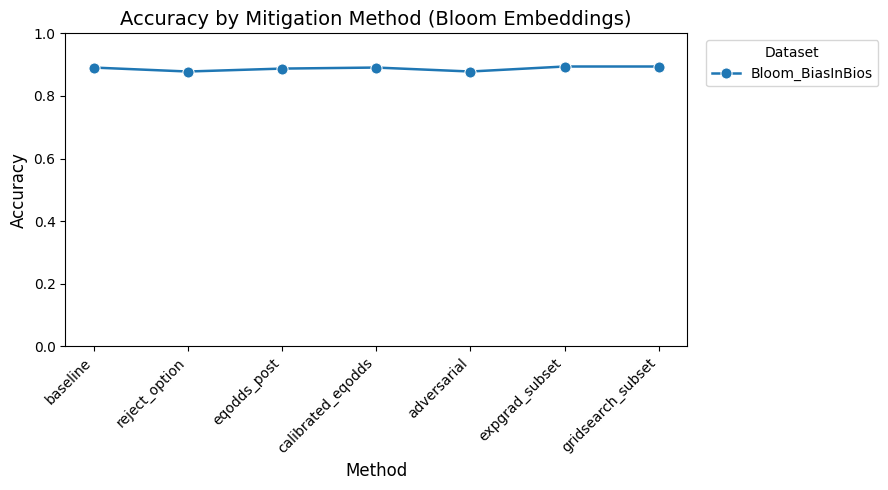

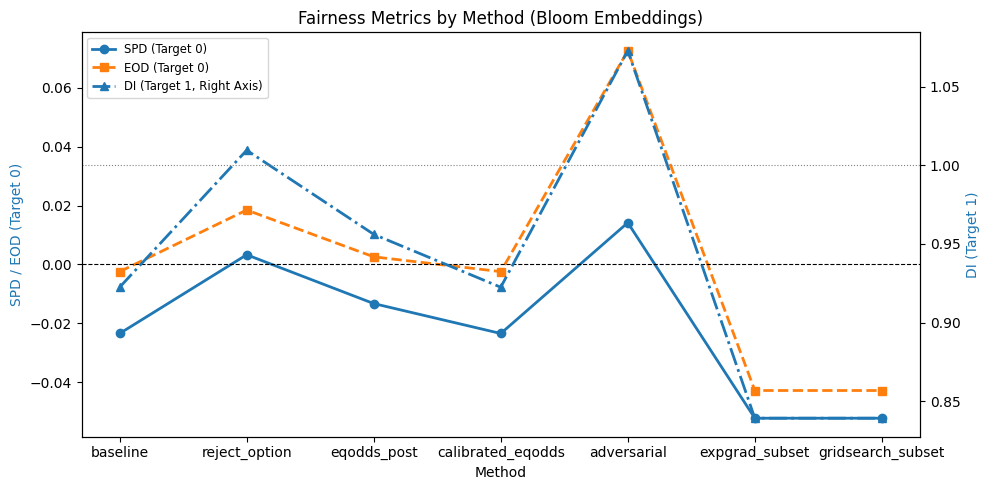

In [11]:
# === Block 9: Fairness Table and Visualization ===

# Display the final results table
table_df = res_df[['method', 'accuracy', 'DI', 'SPD', 'EOD']].copy()
table_df = table_df.rename(columns={
    'method': 'Method',
    'accuracy': 'Accuracy',
    'DI': 'DI (Target 1)',
    'SPD': 'SPD (Target 0)',
    'EOD': 'EOD (Target 0)'
})
table_df = table_df.round(4)
print("\n=== Fairness & Accuracy Table (Bloom Embeddings) ===")
display(table_df)

# --- Accuracy Plot ---
res_df['dataset'] = 'Bloom_BiasInBios' # Label for the plot

# Define a consistent order for methods
preferred_order = ['baseline', 'reject_option', 'eqodds_post', 'calibrated_eqodds',
                   'adversarial', 'prejudiceremover', 'expgrad', 'gridsearch']
order = [m for m in preferred_order if m in res_df['method'].values] + \
        [m for m in res_df['method'].unique() if m not in preferred_order]
res_df['method'] = pd.Categorical(res_df['method'], categories=order, ordered=True)
res_df = res_df.sort_values('method')

plt.figure(figsize=(9,5))
ax = sns.lineplot(
    data=res_df,
    x='method',
    y='accuracy',
    hue='dataset',
    style='dataset',
    markers=True,
    dashes=True,
    markersize=8,
    linewidth=1.8,
    estimator=None
)
ax.set_ylim(0.0, 1.0)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('Method', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.title('Accuracy by Mitigation Method (Bloom Embeddings)', fontsize=14)
plt.legend(title='Dataset', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Combined Fairness Plot (SPD, DI, EOD) ---
methods = list(res_df['method'].astype(str))
spd_vals = res_df['SPD'].astype(float).tolist()
di_vals  = res_df['DI'].astype(float).tolist()
eod_vals = res_df['EOD'].astype(float).tolist()

plt.figure(figsize=(10,5))
plt.plot(methods, spd_vals, marker='o', linestyle='-', linewidth=2, label='SPD (Target 0)')
plt.plot(methods, eod_vals, marker='s', linestyle='--', linewidth=2, label='EOD (Target 0)')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8) # Fairness target for SPD/EOD

# Secondary axis for DI
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(methods, di_vals, marker='^', linestyle='-.', linewidth=2, label='DI (Target 1, Right Axis)')
ax2.axhline(1, color='grey', linestyle=':', linewidth=0.8) # Fairness target for DI

# labels and legend
ax.set_xlabel('Method')
ax.set_ylabel('SPD / EOD (Target 0)', color=ax.get_lines()[0].get_color())
ax2.set_ylabel('DI (Target 1)', color=ax2.get_lines()[0].get_color())
plt.title('Fairness Metrics by Method (Bloom Embeddings)')
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize='small')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

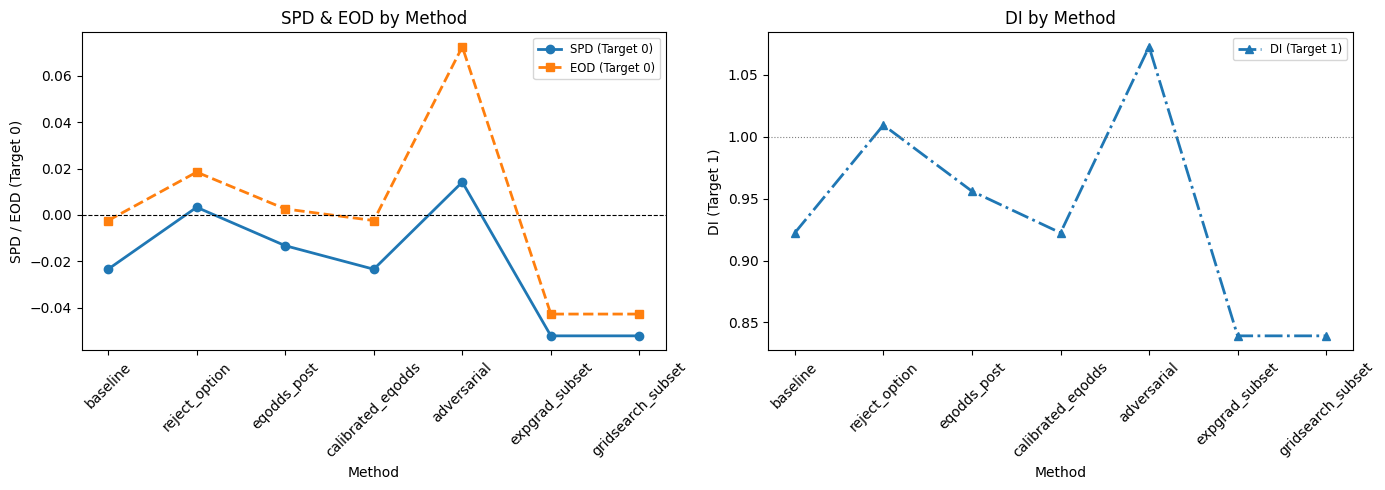

In [12]:
import matplotlib.pyplot as plt

# prepare data
methods = list(res_df['method'].astype(str))
spd_vals = res_df['SPD'].astype(float).tolist()
eod_vals = res_df['EOD'].astype(float).tolist()
di_vals  = res_df['DI'].astype(float).tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), gridspec_kw={'width_ratios':[1,1]})

# Left: SPD & EOD (around 0)
ax1.plot(methods, spd_vals, marker='o', linestyle='-', linewidth=2, label='SPD (Target 0)')
ax1.plot(methods, eod_vals, marker='s', linestyle='--', linewidth=2, label='EOD (Target 0)')
ax1.axhline(0, color='k', linestyle='--', linewidth=0.8)
ax1.set_title('SPD & EOD by Method')
ax1.set_ylabel('SPD / EOD (Target 0)')
ax1.set_xlabel('Method')
ax1.legend(fontsize='small')
ax1.tick_params(axis='x', rotation=45)

# Right: DI (around 1)
ax2.plot(methods, di_vals, marker='^', linestyle='-.', linewidth=2, label='DI (Target 1)')
ax2.axhline(1, color='grey', linestyle=':', linewidth=0.8)
ax2.set_title('DI by Method')
ax2.set_ylabel('DI (Target 1)')
ax2.set_xlabel('Method')
ax2.legend(fontsize='small')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


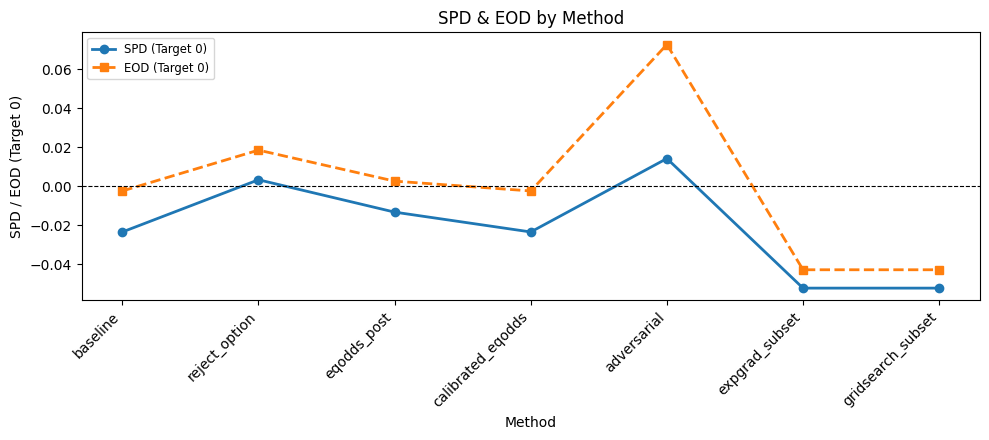

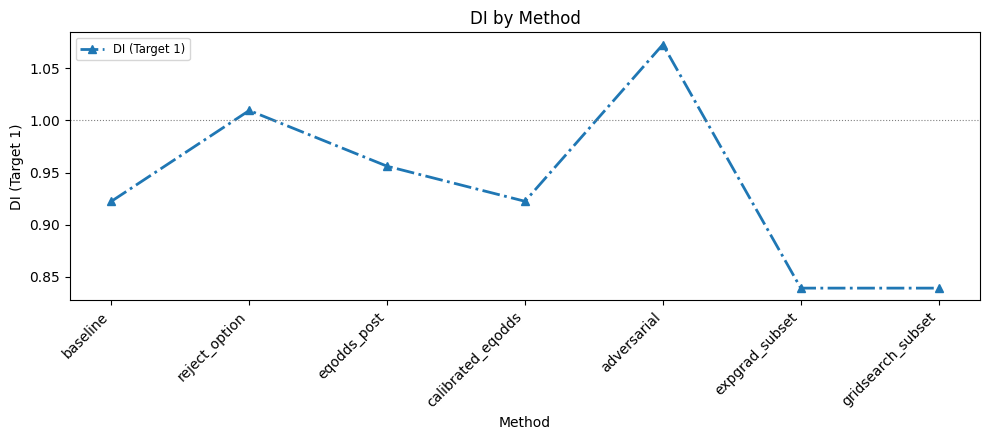

In [13]:
import matplotlib.pyplot as plt

methods = list(res_df['method'].astype(str))
spd_vals = res_df['SPD'].astype(float).tolist()
eod_vals = res_df['EOD'].astype(float).tolist()
di_vals  = res_df['DI'].astype(float).tolist()

# Figure 1: SPD & EOD
plt.figure(figsize=(10,4.5))
plt.plot(methods, spd_vals, marker='o', linestyle='-', linewidth=2, label='SPD (Target 0)')
plt.plot(methods, eod_vals, marker='s', linestyle='--', linewidth=2, label='EOD (Target 0)')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.title('SPD & EOD by Method')
plt.xlabel('Method')
plt.ylabel('SPD / EOD (Target 0)')
plt.legend(loc='upper left', fontsize='small')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Figure 2: DI
plt.figure(figsize=(10,4.5))
plt.plot(methods, di_vals, marker='^', linestyle='-.', linewidth=2, label='DI (Target 1)')
plt.axhline(1, color='grey', linestyle=':', linewidth=0.8)
plt.title('DI by Method')
plt.xlabel('Method')
plt.ylabel('DI (Target 1)')
plt.legend(loc='upper left', fontsize='small')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
